In [ ]:
import sys, os, sys
from pathlib import Path
from jfi import jaxm
import torch, matplotlib.pyplot as plt, numpy as np

root_path = Path("").absolute().parent
if str(root_path) not in sys.path:
    sys.path.append(str(root_path))

from pmpc.experimental import solve as solve_jax
from pmpc import solve as solve_cpu

here_path = Path("").absolute()
if str(here_path) not in sys.path:
    sys.path.append(str(here_path))

from dubins_car import f_np as f_fn, fx_np as fx_fn, fu_np as fu_fn

In [41]:
M, N, xdim, udim = 1, 30, 4, 2

Q = np.tile(np.eye(xdim), (N, 1, 1))
R = np.tile(0. * np.eye(udim), (N, 1, 1))
x0 = np.tile(np.ones(xdim), (1,))
X_ref, U_ref = np.zeros((N, xdim)), np.zeros((N, udim))
X_prev, U_prev = np.zeros((N, xdim)), np.zeros((N, udim))
u_l, u_u = -1 * np.ones((N, udim)), 1 * np.ones((N, udim))

X_ref = 0.4 * np.ones_like(X_ref)

In [54]:
def f_fx_fu_fn(X_prev, U_prev):
    x, u, p = X_prev, U_prev, np.array([1.0, 1.0, 0.3])
    return (
        f_fn(np.asarray(x), np.asarray(u), p),
        fx_fn(np.asarray(x), np.asarray(u), p),
        fu_fn(np.asarray(x), np.asarray(u), p),
    )


def quadratic_cost(X, U):
    X_ref_t = torch.tensor(X_ref)
    c = 0.5 * torch.square(X - X_ref_t).sum(-1).sum(-1)
    return c


def cost_fn(X, U):
    with torch.no_grad():
        if not isinstance(X, torch.Tensor):
            X = torch.as_tensor(np.array(X), dtype=torch.float32)
            U = torch.as_tensor(np.array(U), dtype=torch.float32)

        z = torch.concatenate([X, U], axis=-1)
        J = torch.autograd.functional.jacobian(
            lambda X: quadratic_cost(X, U), X, create_graph=False
        )
        cx = J[0, ..., :xdim]
        cu = J[0, ..., xdim:]
        return cx.detach(), None  # cu.detach()

+------+------------+------------+------------+------------+------------+
|  it  |   elaps    |    obj     |   resid    |   reg_x    |   reg_u    |
+------+------------+------------+------------+------------+------------+
| 0001 |  1.242e-02 |  1.390e-05 |  1.945e+00 |  1.000e+00 |  1.000e-02 |
| 0002 |  2.299e-02 |  1.416e-05 |  1.718e-01 |  1.000e+00 |  1.000e-02 |
| 0003 |  3.240e-02 |  1.422e-05 |  9.075e-02 |  1.000e+00 |  1.000e-02 |
| 0004 |  4.171e-02 |  1.425e-05 |  6.248e-02 |  1.000e+00 |  1.000e-02 |
| 0005 |  5.079e-02 |  1.428e-05 |  4.481e-02 |  1.000e+00 |  1.000e-02 |
| 0006 |  5.977e-02 |  1.431e-05 |  3.266e-02 |  1.000e+00 |  1.000e-02 |
| 0007 |  6.874e-02 |  1.433e-05 |  3.078e-02 |  1.000e+00 |  1.000e-02 |
| 0008 |  7.776e-02 |  1.436e-05 |  2.988e-02 |  1.000e+00 |  1.000e-02 |
| 0009 |  8.678e-02 |  1.438e-05 |  2.893e-02 |  1.000e+00 |  1.000e-02 |
| 0010 |  9.591e-02 |  1.440e-05 |  2.793e-02 |  1.000e+00 |  1.000e-02 |
| 0011 |  1.050e-01 |  1.441e-05 |  2.

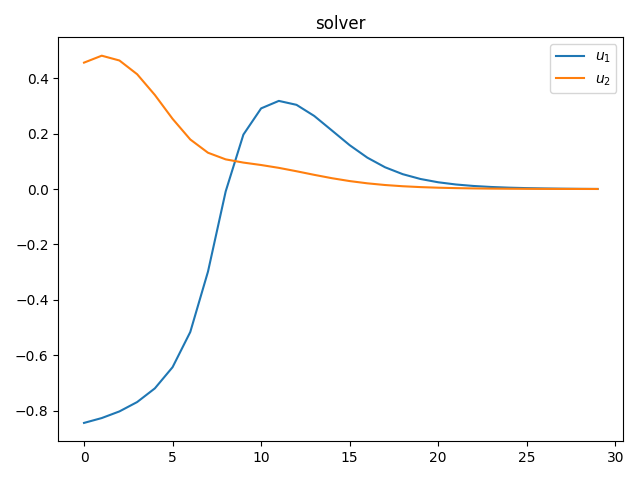

+------+------------+------------+------------+----------+----------+----------+
|  it  |   elaps    |    obj     |   resid    |  reg_x   |  reg_u   |  alpha   |
+------+------------+------------+------------+----------+----------+----------+
| 0001 |  6.846e-02 |  8.843e-01 |  1.945e+00 |  1.0e+00 |  1.0e-02 |  1.0e+02 |
| 0002 |  1.011e-01 | -8.608e-02 |  2.301e-01 |  1.0e+00 |  1.0e-02 |  1.0e+02 |
| 0003 |  1.337e-01 | -8.890e-02 |  1.081e-01 |  1.0e+00 |  1.0e-02 |  1.0e+02 |
| 0004 |  1.626e-01 | -8.929e-02 |  6.553e-02 |  1.0e+00 |  1.0e-02 |  1.0e+02 |
| 0005 |  1.859e-01 | -8.952e-02 |  6.192e-02 |  1.0e+00 |  1.0e-02 |  1.0e+02 |
| 0006 |  2.089e-01 | -8.969e-02 |  5.750e-02 |  1.0e+00 |  1.0e-02 |  1.0e+02 |
| 0007 |  2.316e-01 | -8.981e-02 |  5.267e-02 |  1.0e+00 |  1.0e-02 |  1.0e+02 |
| 0008 |  2.544e-01 | -8.991e-02 |  4.778e-02 |  1.0e+00 |  1.0e-02 |  1.0e+02 |
| 0009 |  2.773e-01 | -8.999e-02 |  4.308e-02 |  1.0e+00 |  1.0e-02 |  1.0e+02 |
| 0010 |  3.001e-01 | -9.007

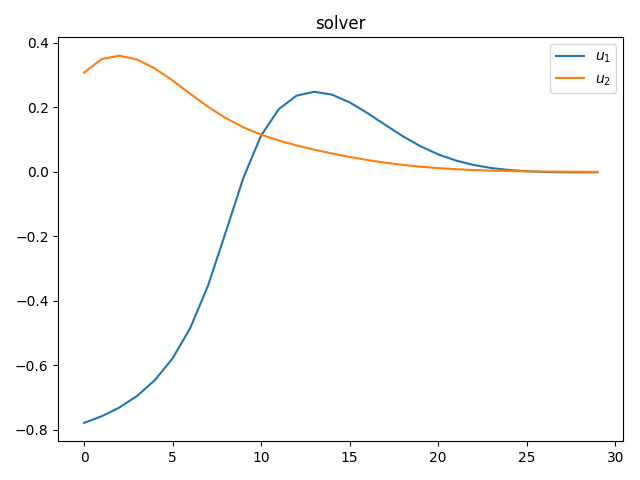

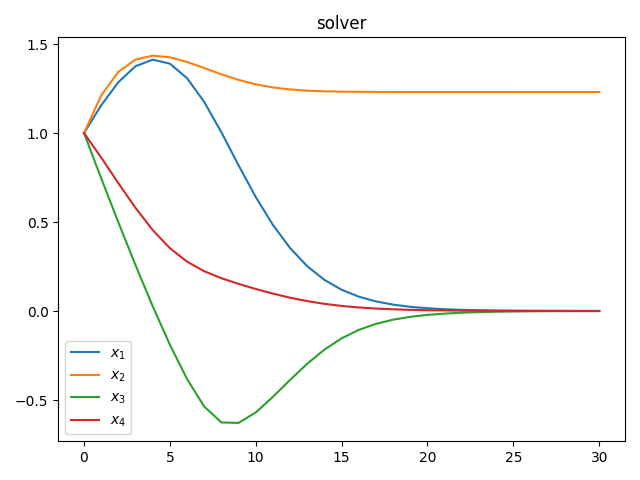

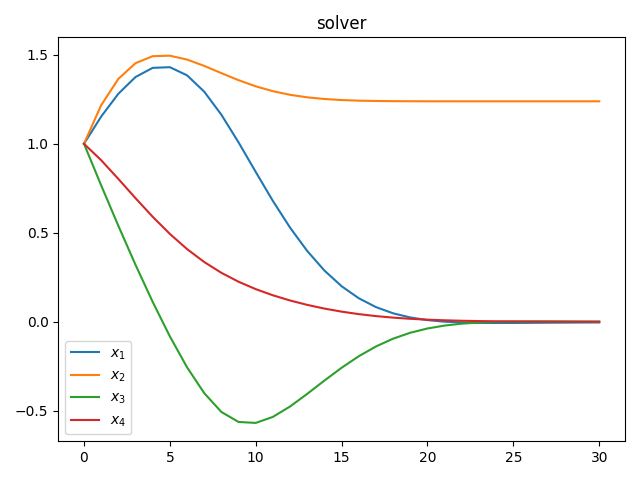

In [51]:
## Convex Cost
Xs, Us = [], []
for solve in [solve_cpu, solve_jax]:
    if solve is solve_jax:
        opts = dict(verbose=True, u_l=u_l, u_u=u_u, device='cpu', dtype=jaxm.float64)
        opts["solver_settings"] = dict(smooth_alpha=1e2)
    else:
        opts = dict(verbose=True, u_l=u_l, u_u=u_u)
        opts["solver_settings"] = dict(smooth_cstr="logbarrier", smooth_alpha=5e2)
    args = (f_fx_fu_fn, Q, R, x0, X_ref, U_ref, X_prev, U_prev)

    X, U, data = solve(*args, max_it=100, **opts)
    Xs.append(X)
    Us.append(U)

    plt.figure()
    plt.title('solver')
    for r in range(xdim):
        plt.plot(X[:, r], label="$x_%d$" % (r + 1))
    plt.legend()
    plt.tight_layout()

    plt.figure()
    plt.title('solver')
    for r in range(udim):
        plt.plot(U[:, r], label="$u_%d$" % (r + 1))
    plt.legend()
    plt.tight_layout()

    plt.show()

In [52]:
jaxm.norm(Xs[0] - Xs[1]) / jaxm.norm(Xs[0])

Array(0.08526794, dtype=float64)

+------+------------+------------+------------+------------+------------+
|  it  |   elaps    |    obj     |   resid    |   reg_x    |   reg_u    |
+------+------------+------------+------------+------------+------------+
| 0001 |  1.169e-02 |  1.939e-05 |  1.944e+00 |  1.000e+01 |  1.000e+00 |
| 0002 |  2.114e-02 |  1.858e-05 |  1.604e-01 |  1.000e+01 |  1.000e+00 |
| 0003 |  2.976e-02 |  1.770e-05 |  9.388e-02 |  1.000e+01 |  1.000e+00 |
| 0004 |  3.856e-02 |  1.699e-05 |  8.335e-02 |  1.000e+01 |  1.000e+00 |
| 0005 |  4.760e-02 |  1.645e-05 |  7.353e-02 |  1.000e+01 |  1.000e+00 |
| 0006 |  5.646e-02 |  1.603e-05 |  6.497e-02 |  1.000e+01 |  1.000e+00 |
| 0007 |  6.529e-02 |  1.570e-05 |  5.748e-02 |  1.000e+01 |  1.000e+00 |
| 0008 |  7.431e-02 |  1.546e-05 |  5.097e-02 |  1.000e+01 |  1.000e+00 |
| 0009 |  8.301e-02 |  1.527e-05 |  4.627e-02 |  1.000e+01 |  1.000e+00 |
| 0010 |  1.129e-01 |  1.512e-05 |  4.207e-02 |  1.000e+01 |  1.000e+00 |
| 0011 |  1.222e-01 |  1.502e-05 |  3.

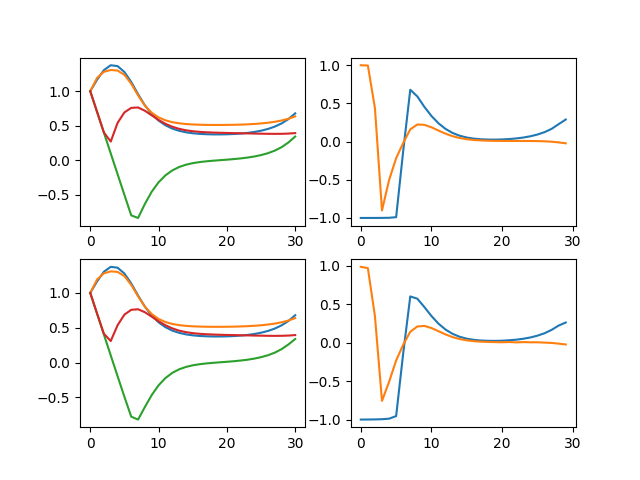

In [55]:
## External Cost
Xs, Us = [], []
ecost = lambda X, U, *args, **kw: cost_fn(X, U)
X_ref_inp = np.zeros_like(X_ref)
fig, ax = plt.subplots(2, 2)
for (i, solve) in enumerate([solve_cpu, solve_jax]):
    opts = dict(
        verbose=True,
        u_l=u_l,
        u_u=u_u,
        reg_x=1e1,
        reg_u=1e0,
    )
    if solve is solve_jax:
        opts = dict(
            opts,
            lin_cost_fn=ecost,
            device="cpu",
            dtype=jaxm.float64,
        )
        opts["solver_settings"] = dict(smooth_alpha=1e2)
    else:
        opts = dict(
            opts,
            cost_fn=ecost,
        )
        opts["solver_settings"] = dict(smooth_alpha=1e3)
    Q = 1e-5 * jaxm.tile(jaxm.eye(Q.shape[-1]), (N, 1, 1))
    args = (f_fx_fu_fn, Q, R, x0, X_ref_inp, U_ref, X_prev, U_prev)

    X, U, data = solve(*args, max_it=100, **opts)
    Xs.append(X)
    Us.append(U)

    for r in range(xdim):
        ax[i, 0].plot(X[:, r], label="$x_%d$" % (r + 1))

    for r in range(udim):
        ax[i, 1].plot(U[:, r], label="$u_%d$" % (r + 1))

plt.show()

In [56]:
jaxm.norm(Xs[0] - Xs[1]) / jaxm.norm(Xs[0])

Array(0.00842169, dtype=float64)